In [57]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

C1D supports two mode:

1. fixed grid

2. zoomed grid with reference to the same files as the original model


Modify config to use the same vertical grid as SalishSeaCast



```
&namdom        !   space and time domain (bathymetry, mesh, timestep)
!-----------------------------------------------------------------------
   nn_bathy    =    0      !  compute (=0) or read (=1) the bathymetry file
   rn_bathy    = 4198.     !  value of the bathymetry. if (=0) bottom flat at jpkm1
   nn_msh      =    0      !  create (=1) a mesh file or not (=0)
   rn_rdt      =  360.     !  time step for the dynamics (and tracer if nn_acc=0)
   rn_rdtmin   =  360.     !  minimum time step on tracers (used if nn_acc=1)
   rn_rdtmax   =  360.     !  maximum time step on tracers (used if nn_acc=1)
   jphgr_msh   =       1                 !  type of horizontal mesh
   ppglam0     =    -150.0               !  longitude of first raw and column T-point (jphgr_msh = 1)
   ppgphi0     =      50.0               ! latitude  of first raw and column T-point (jphgr_msh = 1)
   ppe1_deg    =       0.1               !  zonal      grid-spacing (degrees)
   ppe2_deg    =       0.1               !  meridional grid-spacing (degrees)
   ppe1_m      =  999999.0               !  zonal      grid-spacing (degrees)
   ppe2_m      =  999999.0               !  meridional grid-spacing (degrees)
   ppsur       =  999999.                !  ORCA r4, r2 and r05 coefficients
   ppa0        =  999999.                ! (default coefficients)
   ppa1        =  999999.                !
   ppkth       =      25.                !
   ppacr       =       3.                !
   ppdzmin     =       1.                !  Minimum vertical spacing
   pphmax      =     428.0               !  Maximum depth
   ldbletanh   =  .FALSE.                 !  Use/do not use double tanf function for vertical coordinates
/
!--
```

## Bathymetry

`ln -s ../../../../../grid/bathy_downonegrid2.nc bathymetry.nc`

In [82]:
bathy = xr.open_dataset('bathymetry.nc')

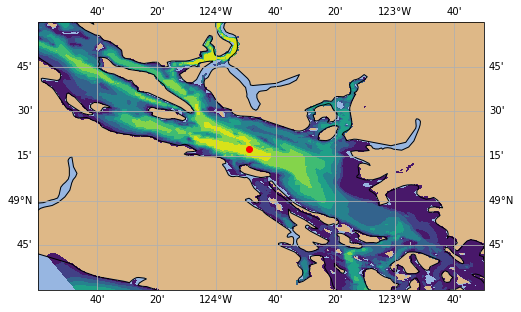

In [350]:
plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-125, -122.5, 48.5, 50], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='#DEB887')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# The data are defined in lat/lon coordinate system, so PlateCarree()
# is the appropriate choice:
data_crs = ccrs.PlateCarree()

# The projection keyword determines how the plot will look
#plt.figure(figsize=(6, 3))

ax.contourf(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, transform=data_crs)


y = 500
x = 240
ax.plot( bathy.nav_lon[y,x], bathy.nav_lat[y,x], 'ro', transform=data_crs)

In [212]:
bathy.nav_lon[y,x].values, bathy.nav_lat[y,x].values, 

(array(-123.81835938), array(49.28987122))

Get temperature and salinity profile from SalishSea Green, Salish Sea, 3d Tracer Fields, Hourly, v19-05	

In [93]:
import erddapy

In [198]:
e = erddapy.ERDDAP(server='https://salishsea.eos.ubc.ca/erddap')

In [199]:
e.dataset_id = 'ubcSSg3DTracerFields1hV19-05'
e.protocol = 'griddap'

In [200]:
e.griddap_initialize()

In [202]:
e.constraints['gridX>='] = x-5
e.constraints['gridX<='] = x+5
e.constraints['gridY>='] = y-5
e.constraints['gridY<='] = y+5

e.constraints['time>='] = '2016-03-23T23:30:00Z'
e.constraints['time<='] = '2016-03-23T23:30:00Z'
e.constraints

{'time>=': '2016-03-23T23:30:00Z',
 'time<=': '2016-03-23T23:30:00Z',
 'time_step': 1,
 'depth>=': 0.5000003,
 'depth<=': 441.4661,
 'depth_step': 1,
 'gridY>=': 495,
 'gridY<=': 505,
 'gridY_step': 1,
 'gridX>=': 235,
 'gridX<=': 245,
 'gridX_step': 1}

In [203]:
ds = e.to_xarray()

In [204]:
ds

<xarray.Dataset>
Dimensions:      (time: 1, depth: 40, gridY: 11, gridX: 11)
Coordinates:
  * time         (time) datetime64[ns] 2016-03-23T23:30:00
  * depth        (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
  * gridY        (gridY) int16 495 496 497 498 499 500 501 502 503 504 505
  * gridX        (gridX) int16 235 236 237 238 239 240 241 242 243 244 245
Data variables:
    salinity     (time, depth, gridY, gridX) float32 ...
    temperature  (time, depth, gridY, gridX) float32 ...
Attributes: (12/29)
    acknowledgement:               MEOPAR, ONC, Compute Canada
    cdm_data_type:                 Grid
    comment:                       If you use this dataset in your research,\...
    Conventions:                   CF-1.6, COARDS, ACDD-1.3
    creator_email:                 sallen@eoas.ubc.ca
    creator_name:                  Salish Sea MEOPAR Project Contributors
    ...                            ...
    testOutOfDate:                 now-16hours
    time_coverage_end:             2016-03-23T23:30:00Z
    time_coverage_start:           2016-03-23T23:30:00Z
    timeStamp:                     2022-Mar-23 18:02:01 GMT
    title:                         Green, Salish Sea, 3d Tracer Fields, Hourl...
    uuid:                          6c1101c1-4e8f-4200-a46d-5c368361537c

(400.0, 0.0)

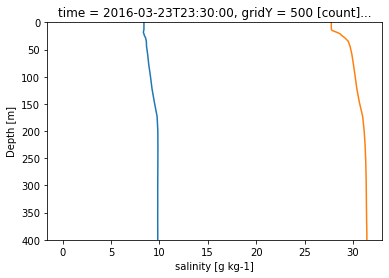

In [208]:
ds.temperature.sel(gridY=y, gridX=x).plot(y='depth')
ds.salinity.sel(gridY=y, gridX=x).plot(y='depth')
plt.ylim(400, 0)

In [14]:
ds.depth

<xarray.DataArray 'depth' (depth: 40)>
array([  0.5     ,   1.500003,   2.500011,   3.500031,   4.500071,   5.500151,
         6.50031 ,   7.500623,   8.501236,   9.502433,  10.504766,  11.509312,
        12.518167,  13.535412,  14.568982,  15.634288,  16.761173,  18.007135,
        19.481785,  21.389978,  24.100256,  28.229916,  34.685757,  44.517723,
        58.484333,  76.58559 ,  98.06296 , 121.866516, 147.08946 , 173.11449 ,
       199.57304 , 226.2603  , 253.06664 , 279.93454 , 306.8342  , 333.75018 ,
       360.67453 , 387.6032  , 414.5341  , 441.4661  ], dtype=float32)
Coordinates:
  * depth    (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
Attributes:
    _ChunkSizes:             40
    _CoordinateAxisType:     Height
    _CoordinateZisPositive:  down
    actual_range:            [  0.5000003 441.4661   ]
    axis:                    Z
    coverage_content_type:   modelResult
    ioos_category:           Location
    long_name:               Depth
    name:                    deptht
    positive:                down
    standard_name:           depth
    units:                   m

In [213]:
initfile = xr.open_dataset('init_PAPASTATION_m06d15.nc')
initfile

<xarray.Dataset>
Dimensions:       (longitude: 3, latitude: 3, deptht: 75, time_counter: 1)
Coordinates:
  * longitude     (longitude) float64 -145.0 -145.0 -145.0
  * latitude      (latitude) float64 50.0 50.0 50.0
  * deptht        (deptht) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) datetime64[ns] 2010-06-14T12:00:00
Data variables:
    votemper      (time_counter, deptht, latitude, longitude) float64 ...
    vosaline      (time_counter, deptht, latitude, longitude) float64 ...

In [411]:
ds = xr.open_dataset('init_SalishSeaCast_m02d01.nc')
ds

<xarray.Dataset>
Dimensions:               (y: 898, x: 398, deptht: 40, axis_nbounds: 2,
                           time_counter: 1)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2016-02-02T12:00:00
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    votemper              (time_counter, deptht, y, x) float32 ...
    vosaline              (time_counter, deptht, y, x) float32 ...
Attributes:
    name:         SalishSeaCast-VNR002_1d_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2022-Jan-19 00:12:06 GMT
    uuid:         23653187-24be-47ec-b660-a569f6e1a28f

In [462]:
for d in range(1, 4):
    date_in = f'201602{d:02d}-201602{d:02d}'
    print(date_in)
    date_out = f'y2016m02d{d:02d}'
    ds_model = xr.open_dataset(f'model_3d/SalishSeaCast-VNR002_1h_grid_U_{date_in}.nc')
    ds_model = ds_model.isel(x=slice(x-1, x+2), y=slice(y-1, y+2))
    ds_model.to_netcdf(f'ucurrent_{date_out}.nc')
    
    ds_model = xr.open_dataset(f'model_3d/SalishSeaCast-VNR002_1h_grid_V_{date_in}.nc')
    ds_model = ds_model.isel(x=slice(x-1, x+2), y=slice(y-1, y+2))
    ds_model.to_netcdf(f'vcurrent_{date_out}.nc')

20160201-20160201
20160202-20160202
20160203-20160203


In [ ]:
for d in range(1, 3):
    date = f'y2016m02d{d:02d}'
    print(date)
    ds_atmdata = xr.open_dataset(f'ATMDATA/ops_{date}.nc')
    ds_atmdata = ds_atmdata.set_coords(['nav_lat', 'nav_lon'])

    ds_forcing = ds_atmdata.isel(x=slice(x_forcing-1, x_forcing+2), y=slice(y_forcing-1, y_forcing+2))
    ds_forcing['snow'] = xr.zeros_like(ds.precip)
    ds_forcing.snow.attrs = {'long_name': 'snow (solid prcipitation)',
     'units': 'Kg/m2/s'}

    ds_forcing.to_netcdf(f'forcing_SalishSea_{date}.nc')

(400.0, 0.0)

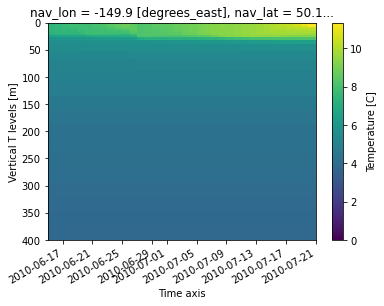

In [36]:
dsT = xr.open_dataset('SalishSea_1d_20100615_20100721_grid_T.nc')
dsT.votemper.isel(x=1, y=1).plot(y='deptht')
plt.ylim(400, 0)

In [28]:
ds.depth

<xarray.DataArray 'depth' (depth: 40)>
array([  0.5     ,   1.500003,   2.500011,   3.500031,   4.500071,   5.500151,
         6.50031 ,   7.500623,   8.501236,   9.502433,  10.504766,  11.509312,
        12.518167,  13.535412,  14.568982,  15.634288,  16.761173,  18.007135,
        19.481785,  21.389978,  24.100256,  28.229916,  34.685757,  44.517723,
        58.484333,  76.58559 ,  98.06296 , 121.866516, 147.08946 , 173.11449 ,
       199.57304 , 226.2603  , 253.06664 , 279.93454 , 306.8342  , 333.75018 ,
       360.67453 , 387.6032  , 414.5341  , 441.4661  ], dtype=float32)
Coordinates:
  * depth    (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
Attributes:
    _ChunkSizes:             40
    _CoordinateAxisType:     Height
    _CoordinateZisPositive:  down
    actual_range:            [  0.5000003 441.4661   ]
    axis:                    Z
    coverage_content_type:   modelResult
    ioos_category:           Location
    long_name:               Depth
    name:                    deptht
    positive:                down
    standard_name:           depth
    units:                   m

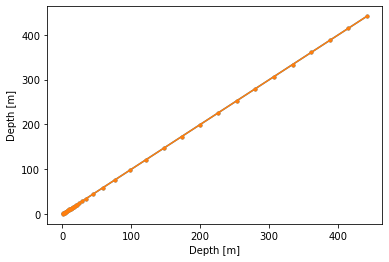

In [29]:
dsT.deptht.plot(marker='.')
ds.depth.plot(marker='.')


## Model output

In [446]:
ds = xr.open_dataset('../../../../../natasha/SalishSeaCast-VNR002_1d_grid_T_20160201-20160201.nc')
ds

<xarray.Dataset>
Dimensions:               (y: 898, x: 398, deptht: 40, axis_nbounds: 2,
                           time_counter: 1)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2016-02-01T12:00:00
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    votemper              (time_counter, deptht, y, x) float32 ...
    vosaline              (time_counter, deptht, y, x) float32 ...
Attributes:
    name:         SalishSeaCast-VNR002_1d_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2022-Jan-18 23:59:00 GMT
    uuid:         2c5d23c2-bab9-476c-8c3a-3728f9740348

See namsbc_sas to avoid calculating the 3D temperature, salintiy and velocity fields and read them from a previous run.

In [463]:
with open('date.file') as f:
    root = f.read()
root = root.strip()

dsT = xr.open_dataset(f'{root}grid_T.nc')
dsU = xr.open_dataset(f'{root}grid_U.nc')
dsV = xr.open_dataset(f'{root}grid_V.nc')
dsW = xr.open_dataset(f'{root}grid_W.nc')

In [464]:
dsT

<xarray.Dataset>
Dimensions:            (y: 3, x: 3, deptht: 40, time_counter: 72, tbnds: 2)
Coordinates:
    nav_lon            (y, x) float32 ...
    nav_lat            (y, x) float32 ...
  * deptht             (deptht) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
  * time_counter       (time_counter) datetime64[ns] 2016-02-01T00:30:00 ... ...
Dimensions without coordinates: y, x, tbnds
Data variables: (12/21)
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] ...
    votemper           (time_counter, deptht, y, x) float32 ...
    vosaline           (time_counter, deptht, y, x) float32 ...
    sosstsst           (time_counter, y, x) float32 ...
    sosaline           (time_counter, y, x) float32 ...
    sossheig           (time_counter, y, x) float32 ...
    ...                 ...
    soicecov           (time_counter, y, x) float32 ...
    sowindsp           (time_counter, y, x) float32 ...
    sohefldp           (time_counter, y, x) float32 ...
    sowafldp           (time_counter, y, x) float32 ...
    sosafldp           (time_counter, y, x) float32 ...
    sobowlin           (y, x) float32 ...
Attributes:
    Conventions:  CF-1.1
    file_name:    SalishSea_1h_20160201_20160203_grid_T.nc
    production:   An IPSL model
    TimeStamp:    2022-MAR-24 12:05:48 GMT-0400

(400.0, 0.0)

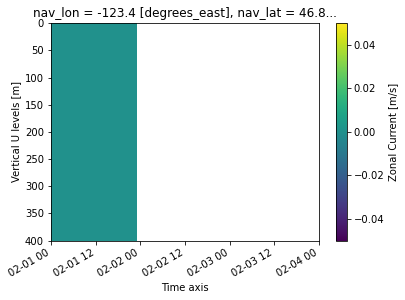

In [445]:
dsU.vozocrtx.isel(x=1, y=1).plot(y='depthu')
plt.ylim(400, 0)

(400.0, 0.0)

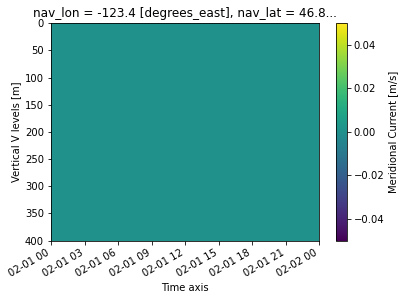

In [402]:
dsV.vomecrty.isel(x=1, y=1).plot(y='depthv')
plt.ylim(400, 0)

(400.0, 0.0)

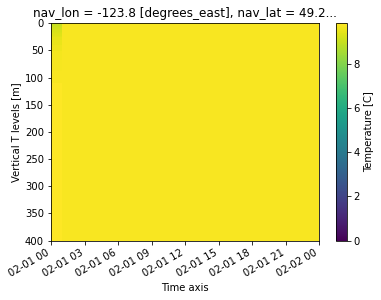

In [394]:
dsT.votemper.isel(x=1, y=1).plot(y='deptht')
plt.ylim(400, 0)

In [410]:
ds = xr.open_dataset('ATMDATA/ops_y2016m02d01.nc')
ds

<xarray.Dataset>
Dimensions:       (time_counter: 24, y: 266, x: 256)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2016-02-01 ... 2016-02-01T23:...
  * x             (x) float64 0.0 2.5e+03 5e+03 ... 6.325e+05 6.35e+05 6.375e+05
  * y             (y) float64 0.0 2.5e+03 5e+03 ... 6.575e+05 6.6e+05 6.625e+05
Data variables:
    atmpres       (time_counter, y, x) float32 ...
    nav_lat       (y, x) float64 ...
    nav_lon       (y, x) float64 ...
    precip        (time_counter, y, x) float32 ...
    qair          (time_counter, y, x) float32 ...
    solar         (time_counter, y, x) float32 ...
    tair          (time_counter, y, x) float32 ...
    therm_rad     (time_counter, y, x) float32 ...
    u_wind        (time_counter, y, x) float32 ...
    v_wind        (time_counter, y, x) float32 ...
Attributes:
    Conventions:          CF-1.0
    History:              Mon Feb  1 10:03:18 2016: ncks -4 -L4 -O /results/f...
    GRIB2_grid_template:  20
    NCO:                  4.4.2

## Determine grid point in forcing file that applies to same location in 

In [410]:
ds = xr.open_dataset('ATMDATA/ops_y2016m02d01.nc')
ds

<xarray.Dataset>
Dimensions:       (time_counter: 24, y: 266, x: 256)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2016-02-01 ... 2016-02-01T23:...
  * x             (x) float64 0.0 2.5e+03 5e+03 ... 6.325e+05 6.35e+05 6.375e+05
  * y             (y) float64 0.0 2.5e+03 5e+03 ... 6.575e+05 6.6e+05 6.625e+05
Data variables:
    atmpres       (time_counter, y, x) float32 ...
    nav_lat       (y, x) float64 ...
    nav_lon       (y, x) float64 ...
    precip        (time_counter, y, x) float32 ...
    qair          (time_counter, y, x) float32 ...
    solar         (time_counter, y, x) float32 ...
    tair          (time_counter, y, x) float32 ...
    therm_rad     (time_counter, y, x) float32 ...
    u_wind        (time_counter, y, x) float32 ...
    v_wind        (time_counter, y, x) float32 ...
Attributes:
    Conventions:          CF-1.0
    History:              Mon Feb  1 10:03:18 2016: ncks -4 -L4 -O /results/f...
    GRIB2_grid_template:  20
    NCO:                  4.4.2

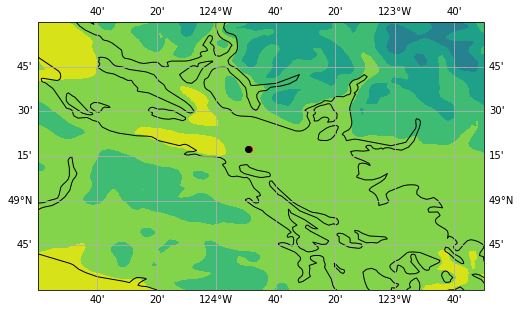

In [366]:
plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-125, -122.5, 48.5, 50], crs=ccrs.PlateCarree())

#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# The data are defined in lat/lon coordinate system, so PlateCarree()
# is the appropriate choice:
data_crs = ccrs.PlateCarree()

# The projection keyword determines how the plot will look
#plt.figure(figsize=(6, 3))

#ax.contourf(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, transform=data_crs)


y_forcing = 147
x_forcing = 137
ax.plot( bathy.nav_lon[y,x], bathy.nav_lat[y,x], 'ro', transform=data_crs)

tair = ds_atmdata.tair.isel(time_counter=0)
ax.contourf(tair.nav_lon, tair.nav_lat, tair, transform=data_crs)
ax.plot( tair.nav_lon[y_forcing,x_forcing], tair.nav_lat[y_forcing,x_forcing], 'ko', transform=data_crs)

ax.add_feature(cfeature.LAND, color='#DEB887', )

In [408]:
for d in range(1, 10):
    date = f'y2016m02d{d:02d}'
    print(date)
    ds_atmdata = xr.open_dataset(f'ATMDATA/ops_{date}.nc')
    ds_atmdata = ds_atmdata.set_coords(['nav_lat', 'nav_lon'])

    ds_forcing = ds_atmdata.isel(x=slice(x_forcing-1, x_forcing+2), y=slice(y_forcing-1, y_forcing+2))
    ds_forcing['snow'] = xr.zeros_like(ds.precip)
    ds_forcing.snow.attrs = {'long_name': 'snow (solid prcipitation)',
     'units': 'Kg/m2/s'}

    ds_forcing.to_netcdf(f'forcing_SalishSea_{date}.nc')

y2016m02d01
y2016m02d02
y2016m02d03
y2016m02d04
y2016m02d05
y2016m02d06
y2016m02d07
y2016m02d08
y2016m02d09


In [467]:
with open('date.file') as f:
    root = f.read()
root = root.strip()

dsT = xr.open_dataset(f'{root}grid_T.nc')
dsU = xr.open_dataset(f'{root}grid_U.nc')
dsV = xr.open_dataset(f'{root}grid_V.nc')
dsW = xr.open_dataset(f'{root}grid_W.nc')

In [468]:
dsU.vozocrtx

<xarray.DataArray 'vozocrtx' (time_counter: 72, depthu: 40, y: 3, x: 3)>
array([[[[ 0., ...,  0.],
         ...,
         [ 0., ...,  0.]],

        ...,

        [[ 0., ...,  0.],
         ...,
         [ 0., ...,  0.]]],


       ...,


       [[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[ 0., ...,  0.],
         ...,
         [ 0., ...,  0.]]]], dtype=float32)
Coordinates:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
  * depthu        (depthu) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * time_counter  (time_counter) datetime64[ns] 2016-02-01T00:30:00 ... 2016-...
Dimensions without coordinates: y, x
Attributes:
    units:               m/s
    standard_name:       Zonal Current
    long_name:           Zonal Current
    online_operation:    ave(x)
    interval_operation:  40.0
    interval_write:      3600.0